# Test model output

The following notebook contains tests of the output generated by model.
The tests check the legality of predicted moves and the correctness of predicted game result.

The tests are performed for model trained on simple tokenization (11 tokens)

In [1]:
import math
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from model import GPTConfig, GPT
from c4engine import C4Engine

In [2]:
OUT_DIR = 'out-connect-four-simple'
DEVICE = 'cuda'

In [3]:
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=DEVICE, dtype=ptdtype)

Load model

In [4]:
# init from a model saved in a specific directory
ckpt_path = os.path.join(OUT_DIR, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=DEVICE)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(DEVICE)
# model = torch.compile(model)

number of parameters: 10.63M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(11, 384)
    (wpe): Embedding(44, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=11, bias=False)
)

Load dataset

In [5]:
# read metadata
data_dir = os.path.join('data', checkpoint['config']['dataset'])
meta_path = os.path.join(data_dir, 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)

# get encode/decode - tokenizer
stoi, itos, stom, separator = meta['stoi'], meta['itos'], meta['stom'], meta['separator']
split = lambda s: list(s) if separator == '' else s.split(separator)
encode = lambda s: [stoi[c] for c in split(s)]
decode = lambda l: separator.join(itos[i] for i in l)
str_to_moves = lambda s: ''.join(stom[c] for c in split(s))
ids_to_moves = lambda l: ''.join(stom[itos[i]] for i in l)

eos_token_ids = meta['eos_token_ids']

# read dataset
block_size = meta['block_size']
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)

## Legal move and game result prediction

In [6]:
def test_legal_move_and_game_result_prediction(data):
    move_seqs = set()
    correct_legal, total_legal = 0, 0
    correct_result, total_result = 0, 0

    for seq in data:
        engine = C4Engine()
        seq_moves = ids_to_moves(seq)
        for i in range(len(seq)):
            engine.make_move(seq_moves[i])

            if seq_moves[:i+1] in move_seqs:
                continue
            move_seqs.add(seq_moves[:i+1])

            # predict next token (move or game result)
            x = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
            y = model.generate(idx=x, max_new_tokens=1, top_k=1)
            predicted = ids_to_moves(y[0].tolist())[-1]

            # if game finished check predicted result
            if engine.result() is not None:
                if predicted == engine.result():
                    correct_result += 1
                total_result += 1
                break

            # check if predicted move is legal
            if engine.is_legal_move(predicted):
                correct_legal += 1
            total_legal += 1

    return correct_legal, total_legal, correct_result, total_result

In [7]:
correct_legal_val, total_legal_val, correct_result_val, total_result_val = test_legal_move_and_game_result_prediction(val_data)

In [8]:
print(f"Legal moves predicted (validation data): {correct_legal_val}/{total_legal_val} ({100.0*correct_legal_val/total_legal_val:.2f}%)")
print(f"Game result predicted (validation data): {correct_result_val}/{total_result_val} ({100.0*correct_result_val/total_result_val:.2f}%)")

Legal moves predicted (validation data): 59234/59665 (99.28%)
Game result predicted (validation data): 1691/2000 (84.55%)


In [9]:
correct_legal_train, total_legal_train, correct_result_train, total_result_train = test_legal_move_and_game_result_prediction(train_data)

In [10]:
print(f"Legal moves predicted (training data): {correct_legal_train}/{total_legal_train} ({100.0*correct_legal_train/total_legal_train:.2f}%)")
print(f"Game result predicted (training data): {correct_result_train}/{total_result_train} ({100.0*correct_result_train/total_result_train:.2f}%)")

Legal moves predicted (training data): 495689/498639 (99.41%)
Game result predicted (training data): 16097/18000 (89.43%)


## Probing

### Get output from hidden layers of the model

In [6]:
activations = {}
k_cache = {}
v_cache = {}

def get_hook(name):
    def hook(block, input, output):
        # get activations - i-th layer output (for last token only)
        activations[name] = output[:, -1, :].detach().cpu()

        # get Q,K,V values for i-th layer
        attn = block.attn
        k_cache[name] = attn.last_k
        v_cache[name] = attn.last_v

    return hook

# Register hooks on each block
for i, block in enumerate(model.transformer.h):
    block.register_forward_hook(get_hook(f'block_{i}'))

### Prepare dataset

In [7]:
field_to_int = {C4Engine.EMPTY: 0, C4Engine.PLAYERS[0]: 1, C4Engine.PLAYERS[1]: 2}
rng = np.random.default_rng(seed=9128)

def get_probe_dataset(data):
    move_seqs = set()
    X = {f'block_{i}': [] for i, _ in enumerate(model.transformer.h)}
    K = {f'block_{i}': [] for i, _ in enumerate(model.transformer.h)}
    V = {f'block_{i}': [] for i, _ in enumerate(model.transformer.h)}
    KV_mask = {f'block_{i}': [] for i, _ in enumerate(model.transformer.h)}
    Y_cell = []
    Y_col = []
    Y_row = []

    for seq in data:
        i = rng.integers(1, len(seq))
        seq_moves = ids_to_moves(seq[:i])
        # seq_moves = ids_to_moves(seq)
        # engine = C4Engine()
        # for i in range(len(seq)):
        # engine.make_move(seq_moves[i])
        engine = C4Engine(seq_moves)

        # if seq_moves[:i+1] in move_seqs:
        #     continue
        # move_seqs.add(seq_moves[:i+1])
        if seq_moves in move_seqs:
            continue
        move_seqs.add(seq_moves)

        board = engine.board()

        inp = (torch.tensor(seq[:i], dtype=torch.long, device=DEVICE)[None, ...])
        # inp = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
        _, _ = model(inp)
        for block in X.keys():
            X[block].append(activations[block].reshape(-1).cpu())
        for block in K.keys():
            K[block].append(k_cache[block])
        for block in V.keys():
            V[block].append(v_cache[block])
        Y_cell.append(torch.tensor([field_to_int[f] for row in board for f in row]))
        Y_col.append(torch.tensor([sum(1 for i in range(6) if board[i][j] in C4Engine.PLAYERS) for j in range(7)]))
        Y_row.append(torch.tensor([sum(1 for c in row if c in C4Engine.PLAYERS) for row in board]))

        # if engine.result() is not None:
        #     break

    N = len(Y_cell)

    for block in K.keys():
        Ks = K[block]
        Vs = V[block]

        T_max = max(k.shape[-2] for k in Ks)
        h = Ks[0].shape[1]
        d = Ks[0].shape[-1]

        K_pad = torch.zeros(N, T_max, d*h)
        V_pad = torch.zeros(N, T_max, d*h)
        mask  = torch.zeros(N, T_max, dtype=torch.bool)

        for i,(k,v) in enumerate(zip(Ks,Vs)):
            T = k.shape[-2]
            K_pad[i, :T, :] = k.squeeze(0).transpose(0,1).reshape(T, -1)
            V_pad[i, :T, :] = v.squeeze(0).transpose(0,1).reshape(T, -1)
            mask[i, :T] = 1

        K[block] = K_pad
        V[block] = V_pad
        KV_mask[block] = mask

    X = {block : torch.stack(X[block]) for block in X.keys()}
    Y_cell = torch.stack(Y_cell)
    Y_col = torch.stack(Y_col)
    Y_row = torch.stack(Y_row)

    return X, K, V, KV_mask, Y_cell, Y_col, Y_row

In [8]:
train_X, train_K, train_V, train_KV_mask, train_Y_cell, train_Y_col, train_Y_row = get_probe_dataset(train_data)

In [9]:
train_X['block_0'].shape, train_Y_cell.shape, train_Y_col.shape, train_Y_row.shape

(torch.Size([16304, 384]),
 torch.Size([16304, 42]),
 torch.Size([16304, 7]),
 torch.Size([16304, 6]))

In [10]:
train_K['block_0'].shape, train_V['block_0'].shape, train_KV_mask['block_0'].shape

(torch.Size([16304, 44, 384]),
 torch.Size([16304, 44, 384]),
 torch.Size([16304, 44]))

In [11]:
val_X, val_K, val_V, val_KV_mask, val_Y_cell, val_Y_col, val_Y_row = get_probe_dataset(val_data)

In [12]:
val_X['block_0'].shape, val_Y_cell.shape, val_Y_col.shape, val_Y_row.shape

(torch.Size([1892, 384]),
 torch.Size([1892, 42]),
 torch.Size([1892, 7]),
 torch.Size([1892, 6]))

In [13]:
val_K['block_0'].shape, val_V['block_0'].shape, val_KV_mask['block_0'].shape

(torch.Size([1892, 44, 384]),
 torch.Size([1892, 44, 384]),
 torch.Size([1892, 44]))

### Train linear probes

In [12]:
class LinearBoardProbe(nn.Module):
    def __init__(self, dim_x, dim_y, num_cls):
        super().__init__()
        # 42 cells × 3 classes
        self._dim_x = dim_x
        self._dim_y = dim_y
        self._num_cls = num_cls
        self.linear = nn.Linear(dim_x, dim_y * num_cls, device=DEVICE)

    def forward(self, x):
        # x: (B,384)
        out = self.linear(x)
        return out.view(-1, self._dim_y, self._num_cls)

In [13]:
def get_data_loader(X, Y, batch_size=1024):
    dataset = torch.utils.data.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)

In [14]:
def train_probe(train_X, train_Y, val_X, val_Y, num_cls):
    results = {}
    for block in train_X.keys():
        print(block)

        probe = LinearBoardProbe(dim_x=train_X[block].shape[-1], dim_y=train_Y.shape[-1], num_cls=num_cls).to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(
            probe.parameters(),
            lr=3e-4,
            weight_decay=1e-4
        )

        epochs = 1024
        batch_size = 1024

        train_loader = get_data_loader(train_X[block], train_Y, batch_size)
        val_loader = get_data_loader(val_X[block], val_Y, batch_size)

        for epoch in range(epochs):
            total_loss = 0
            for x, y in train_loader:
                x = x.to(DEVICE)
                y = y.to(DEVICE)

                preds = probe(x)

                loss = criterion(
                    preds.view(-1, probe._num_cls),
                    y.view(-1)
                )

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            if epoch % 200 == 0:
                print(f'Epoch {epoch:3d}: {total_loss/len(train_loader):.4f}')

        print(f'Epoch {epoch:3d}: {total_loss/len(train_loader):.4f}')
        results[block] = (probe, train_loader, val_loader)

    return results

Predict value of each cell

In [15]:
cell_probe_results = train_probe(train_X, train_Y_cell, val_X, val_Y_cell, num_cls=3)

block_0
Epoch   0: 1.1406
Epoch 200: 0.4975
Epoch 400: 0.4843
Epoch 600: 0.4792
Epoch 800: 0.4764
Epoch 1000: 0.4749
Epoch 1023: 0.4747
block_1
Epoch   0: 1.1691
Epoch 200: 0.4007
Epoch 400: 0.3896
Epoch 600: 0.3855
Epoch 800: 0.3832
Epoch 1000: 0.3817
Epoch 1023: 0.3817
block_2
Epoch   0: 1.2103
Epoch 200: 0.3893
Epoch 400: 0.3781
Epoch 600: 0.3738
Epoch 800: 0.3716
Epoch 1000: 0.3699
Epoch 1023: 0.3702
block_3
Epoch   0: 1.2829
Epoch 200: 0.3837
Epoch 400: 0.3721
Epoch 600: 0.3674
Epoch 800: 0.3650
Epoch 1000: 0.3633
Epoch 1023: 0.3630
block_4
Epoch   0: 1.3829
Epoch 200: 0.3832
Epoch 400: 0.3710
Epoch 600: 0.3659
Epoch 800: 0.3632
Epoch 1000: 0.3612
Epoch 1023: 0.3611
block_5
Epoch   0: 1.4086
Epoch 200: 0.3840
Epoch 400: 0.3707
Epoch 600: 0.3653
Epoch 800: 0.3623
Epoch 1000: 0.3604
Epoch 1023: 0.3604


Predict number of pieces in each column

In [16]:
col_probe_results = train_probe(train_X, train_Y_col, val_X, val_Y_col, num_cls=7)

block_0
Epoch   0: 1.9592
Epoch 200: 0.7756
Epoch 400: 0.7118
Epoch 600: 0.6827
Epoch 800: 0.6653
Epoch 1000: 0.6538
Epoch 1023: 0.6525
block_1
Epoch   0: 2.1309
Epoch 200: 0.4008
Epoch 400: 0.3243
Epoch 600: 0.2929
Epoch 800: 0.2758
Epoch 1000: 0.2650
Epoch 1023: 0.2636
block_2
Epoch   0: 2.2126
Epoch 200: 0.3276
Epoch 400: 0.2622
Epoch 600: 0.2349
Epoch 800: 0.2200
Epoch 1000: 0.2101
Epoch 1023: 0.2091
block_3
Epoch   0: 2.3217
Epoch 200: 0.3073
Epoch 400: 0.2436
Epoch 600: 0.2158
Epoch 800: 0.1999
Epoch 1000: 0.1900
Epoch 1023: 0.1891
block_4
Epoch   0: 2.4994
Epoch 200: 0.3133
Epoch 400: 0.2473
Epoch 600: 0.2187
Epoch 800: 0.2019
Epoch 1000: 0.1912
Epoch 1023: 0.1905
block_5
Epoch   0: 2.3853
Epoch 200: 0.3201
Epoch 400: 0.2537
Epoch 600: 0.2247
Epoch 800: 0.2076
Epoch 1000: 0.1959
Epoch 1023: 0.1952


Predict number of pieces in each row

In [17]:
row_probe_results = train_probe(train_X, train_Y_row, val_X, val_Y_row, num_cls=8)

block_0
Epoch   0: 2.1093
Epoch 200: 0.7232
Epoch 400: 0.6838
Epoch 600: 0.6660
Epoch 800: 0.6559
Epoch 1000: 0.6487
Epoch 1023: 0.6484
block_1
Epoch   0: 2.0880
Epoch 200: 0.6118
Epoch 400: 0.5670
Epoch 600: 0.5464
Epoch 800: 0.5337
Epoch 1000: 0.5250
Epoch 1023: 0.5239
block_2
Epoch   0: 2.2604
Epoch 200: 0.5666
Epoch 400: 0.5187
Epoch 600: 0.4962
Epoch 800: 0.4822
Epoch 1000: 0.4730
Epoch 1023: 0.4723
block_3
Epoch   0: 2.3495
Epoch 200: 0.5557
Epoch 400: 0.5059
Epoch 600: 0.4822
Epoch 800: 0.4679
Epoch 1000: 0.4572
Epoch 1023: 0.4559
block_4
Epoch   0: 2.2906
Epoch 200: 0.5557
Epoch 400: 0.5043
Epoch 600: 0.4794
Epoch 800: 0.4639
Epoch 1000: 0.4529
Epoch 1023: 0.4519
block_5
Epoch   0: 2.6054
Epoch 200: 0.5668
Epoch 400: 0.5112
Epoch 600: 0.4850
Epoch 800: 0.4688
Epoch 1000: 0.4580
Epoch 1023: 0.4566


### Test linear probes

In [18]:
def eval_probe_results(probe_results, dim):
    train_accuracies = {}
    val_accuracies = {}

    for block in probe_results.keys():
        probe, train_loader, val_loader = probe_results[block]

        def eval_loader(loader):
            correct = torch.zeros(dim, device=DEVICE)
            total = torch.zeros(dim, device=DEVICE)

            with torch.no_grad():
                for x, y in loader:
                    x = x.to(DEVICE)
                    y = y.to(DEVICE)

                    preds = probe(x)
                    pred_cls = preds.argmax(dim=-1)
                    matches = (pred_cls == y).float()

                    correct += matches.sum(dim=0)
                    total += torch.ones_like(matches).sum(dim=0)

            return correct / total

        train_accuracies[block] = eval_loader(train_loader)
        val_accuracies[block] = eval_loader(val_loader)

    return train_accuracies, val_accuracies

In [14]:
def plot_heatmaps(acc_dict, w, h, title, xlabel, ylabel, disable_yticks=False, disable_xticks=False, max_cols=3):
    keys = sorted(acc_dict.keys())
    n = len(keys)

    # Grid layout
    cols = min(n, max_cols)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(
        rows,
        cols,
        figsize=(4 * cols, 4 * rows),
        squeeze=False
    )

    fig.suptitle(title, fontsize=16)

    for idx, key in enumerate(keys):
        r = idx // cols
        c = idx % cols
        ax = axes[r][c]
        board = acc_dict[key].view(h, w).cpu()
        im = ax.imshow(board, vmin=0.4, vmax=1)
        ax.set_title(key)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

        if disable_yticks:
            ax.set_yticks([])
        if disable_xticks:
            ax.set_xticks([])

        # Cell values
        for i in range(h):
            for j in range(w):
                val = board[i, j].item()
                ax.text(
                    j, i,
                    f"{val:.2f}",
                    ha="center",
                    va="center",
                    fontsize=9
                )

    # Remove empty subplots
    for i in range(n, rows * cols):
        fig.delaxes(axes[i // cols][i % cols])

    # Shared colorbar
    plt.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="Accuracy")

    plt.show()

Per cell

In [36]:
train_acc_cell, val_acc_cell = eval_probe_results(cell_probe_results, dim=train_Y_cell.shape[-1])

In [37]:
train_acc_cell

{'block_0': tensor([0.8194, 0.8288, 0.8299, 0.7999, 0.8757, 0.9157, 0.9466, 0.7857, 0.7794,
         0.7710, 0.7347, 0.8185, 0.8783, 0.9215, 0.7339, 0.7185, 0.7037, 0.6682,
         0.7422, 0.7980, 0.8654, 0.7064, 0.6991, 0.6936, 0.6820, 0.7271, 0.7777,
         0.8397, 0.6803, 0.6706, 0.6518, 0.6378, 0.6776, 0.7313, 0.7920, 0.6725,
         0.6378, 0.6362, 0.6509, 0.6376, 0.6768, 0.7028], device='cuda:0'),
 'block_1': tensor([0.8740, 0.8786, 0.8735, 0.8585, 0.9051, 0.9384, 0.9645, 0.8329, 0.8234,
         0.8215, 0.7994, 0.8626, 0.9068, 0.9430, 0.7732, 0.7628, 0.7610, 0.7365,
         0.7959, 0.8484, 0.9041, 0.7466, 0.7372, 0.7319, 0.7167, 0.7737, 0.8112,
         0.8686, 0.7238, 0.7001, 0.6852, 0.6680, 0.7287, 0.7686, 0.8202, 0.6917,
         0.6735, 0.6666, 0.7057, 0.6949, 0.7162, 0.7574], device='cuda:0'),
 'block_2': tensor([0.8811, 0.8841, 0.8852, 0.8678, 0.9112, 0.9428, 0.9696, 0.8399, 0.8316,
         0.8276, 0.8078, 0.8666, 0.9082, 0.9473, 0.7804, 0.7691, 0.7658, 0.7352,
     

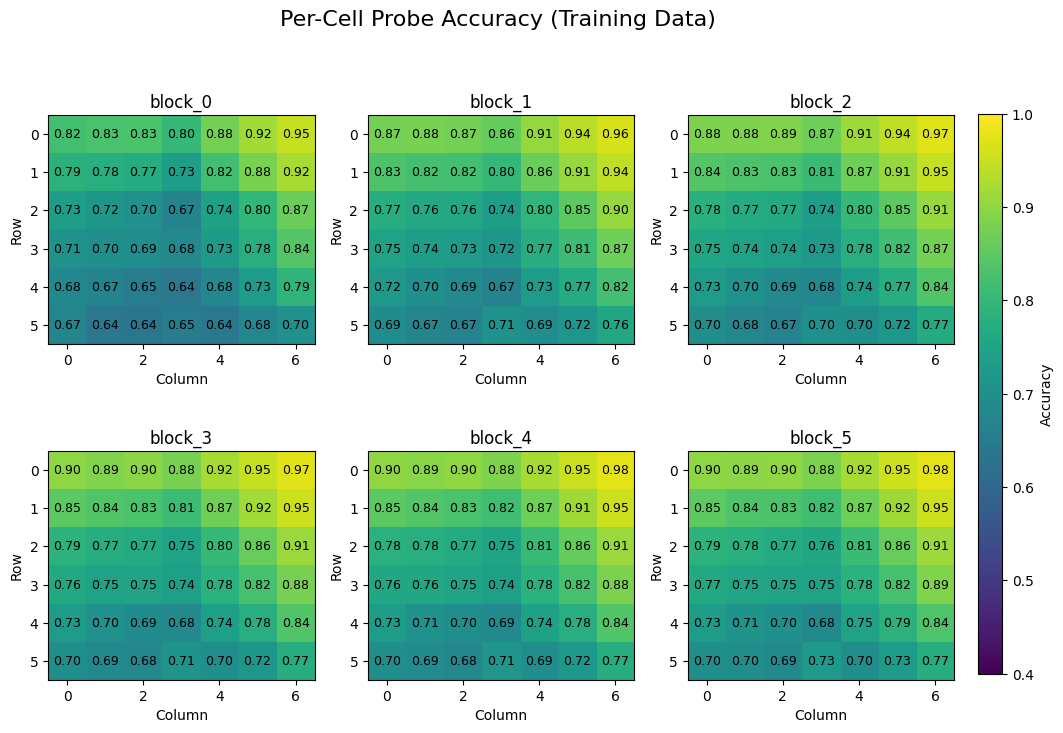

In [38]:
plot_heatmaps(train_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Training Data)', xlabel='Column', ylabel='Row')

In [39]:
val_acc_cell

{'block_0': tensor([0.8161, 0.8235, 0.8319, 0.7939, 0.8488, 0.9064, 0.9434, 0.7733, 0.7616,
         0.7637, 0.7162, 0.8113, 0.8621, 0.9175, 0.7061, 0.7109, 0.6760, 0.6527,
         0.7130, 0.7833, 0.8631, 0.6871, 0.6860, 0.6649, 0.6718, 0.7098, 0.7717,
         0.8235, 0.6686, 0.6612, 0.6438, 0.6279, 0.6755, 0.7067, 0.7616, 0.6512,
         0.6327, 0.6189, 0.6390, 0.6411, 0.6670, 0.6755], device='cuda:0'),
 'block_1': tensor([0.8547, 0.8658, 0.8716, 0.8377, 0.8800, 0.9318, 0.9588, 0.8076, 0.8081,
         0.8002, 0.7770, 0.8362, 0.8821, 0.9339, 0.7558, 0.7643, 0.7341, 0.7310,
         0.7849, 0.8272, 0.8948, 0.7193, 0.7125, 0.6982, 0.7024, 0.7341, 0.7907,
         0.8531, 0.7119, 0.6866, 0.6512, 0.6596, 0.7135, 0.7468, 0.7939, 0.6601,
         0.6660, 0.6416, 0.6897, 0.6913, 0.6929, 0.7304], device='cuda:0'),
 'block_2': tensor([0.8647, 0.8695, 0.8774, 0.8547, 0.8848, 0.9339, 0.9641, 0.8155, 0.8092,
         0.7939, 0.7807, 0.8436, 0.8864, 0.9329, 0.7648, 0.7574, 0.7267, 0.7141,
     

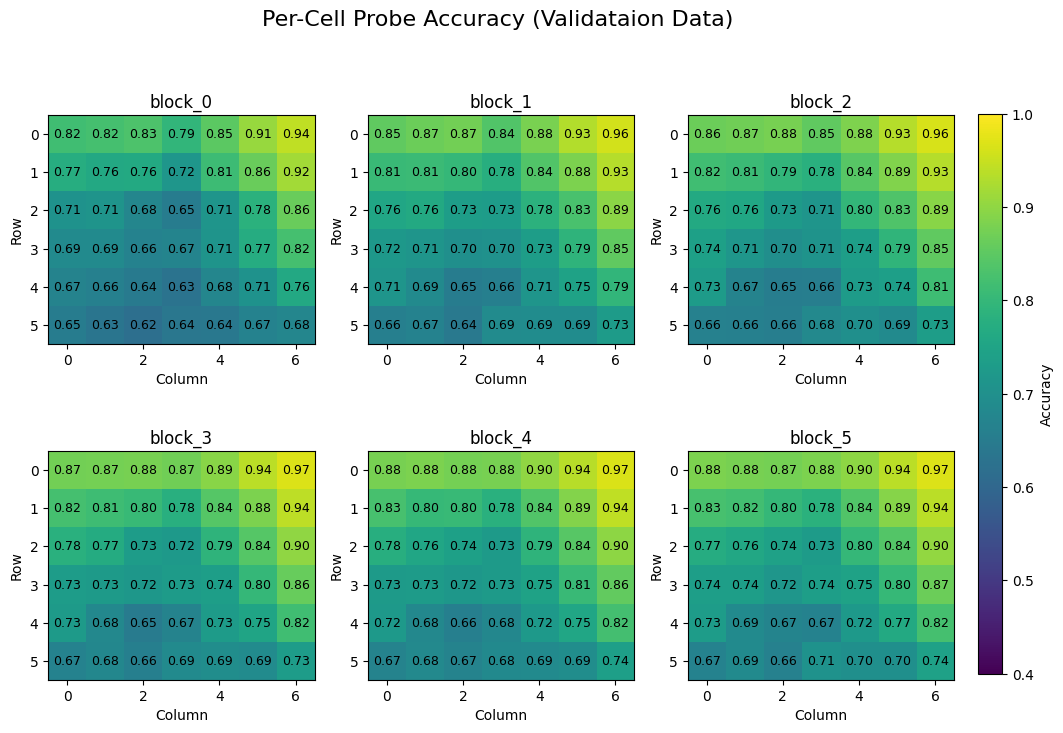

In [40]:
plot_heatmaps(val_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Validataion Data)', xlabel='Column', ylabel='Row')

Per column

In [41]:
train_acc_col, val_acc_col = eval_probe_results(col_probe_results, dim=train_Y_col.shape[-1])

In [42]:
train_acc_col

{'block_0': tensor([0.7477, 0.7244, 0.7388, 0.7414, 0.7321, 0.7588, 0.7663],
        device='cuda:0'),
 'block_1': tensor([0.9173, 0.9132, 0.9197, 0.9334, 0.9136, 0.9053, 0.9123],
        device='cuda:0'),
 'block_2': tensor([0.9435, 0.9271, 0.9381, 0.9528, 0.9308, 0.9221, 0.9197],
        device='cuda:0'),
 'block_3': tensor([0.9500, 0.9342, 0.9480, 0.9621, 0.9346, 0.9298, 0.9241],
        device='cuda:0'),
 'block_4': tensor([0.9460, 0.9344, 0.9457, 0.9617, 0.9347, 0.9282, 0.9206],
        device='cuda:0'),
 'block_5': tensor([0.9425, 0.9333, 0.9447, 0.9599, 0.9326, 0.9252, 0.9228],
        device='cuda:0')}

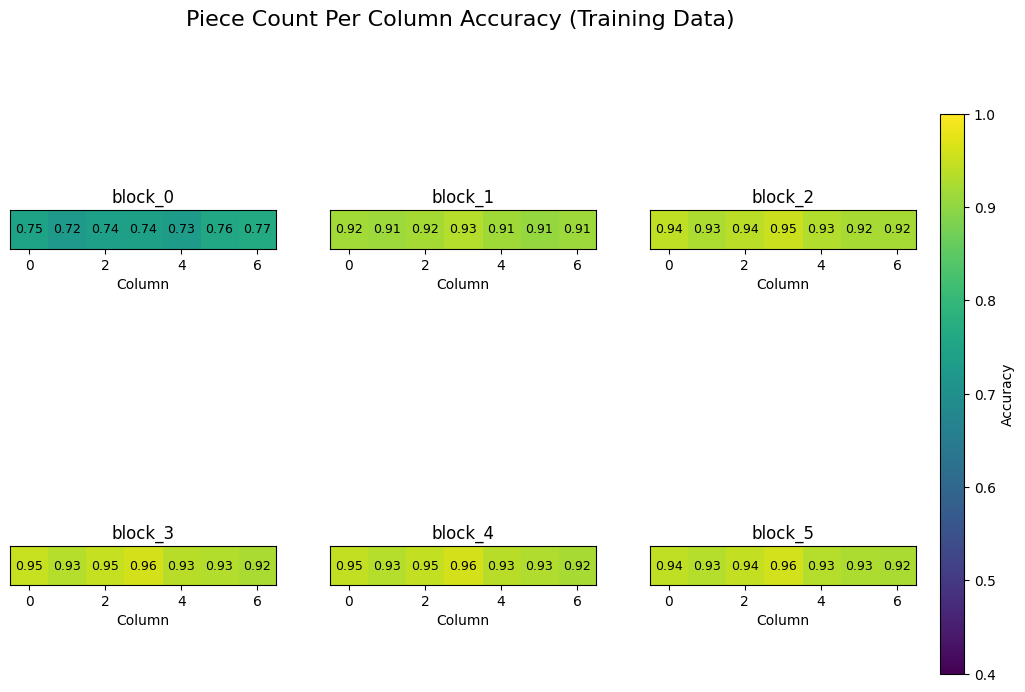

In [43]:
plot_heatmaps(train_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Training Data)', xlabel='Column', ylabel='', disable_yticks=True)

In [44]:
val_acc_col

{'block_0': tensor([0.7410, 0.6998, 0.7347, 0.7315, 0.7188, 0.7368, 0.7415],
        device='cuda:0'),
 'block_1': tensor([0.9133, 0.8922, 0.9022, 0.9212, 0.9033, 0.8938, 0.8853],
        device='cuda:0'),
 'block_2': tensor([0.9329, 0.9080, 0.9144, 0.9323, 0.9138, 0.8985, 0.8927],
        device='cuda:0'),
 'block_3': tensor([0.9345, 0.9186, 0.9292, 0.9360, 0.9175, 0.9027, 0.8869],
        device='cuda:0'),
 'block_4': tensor([0.9265, 0.9054, 0.9244, 0.9371, 0.9191, 0.9001, 0.8911],
        device='cuda:0'),
 'block_5': tensor([0.9244, 0.9107, 0.9191, 0.9382, 0.9112, 0.8964, 0.8959],
        device='cuda:0')}

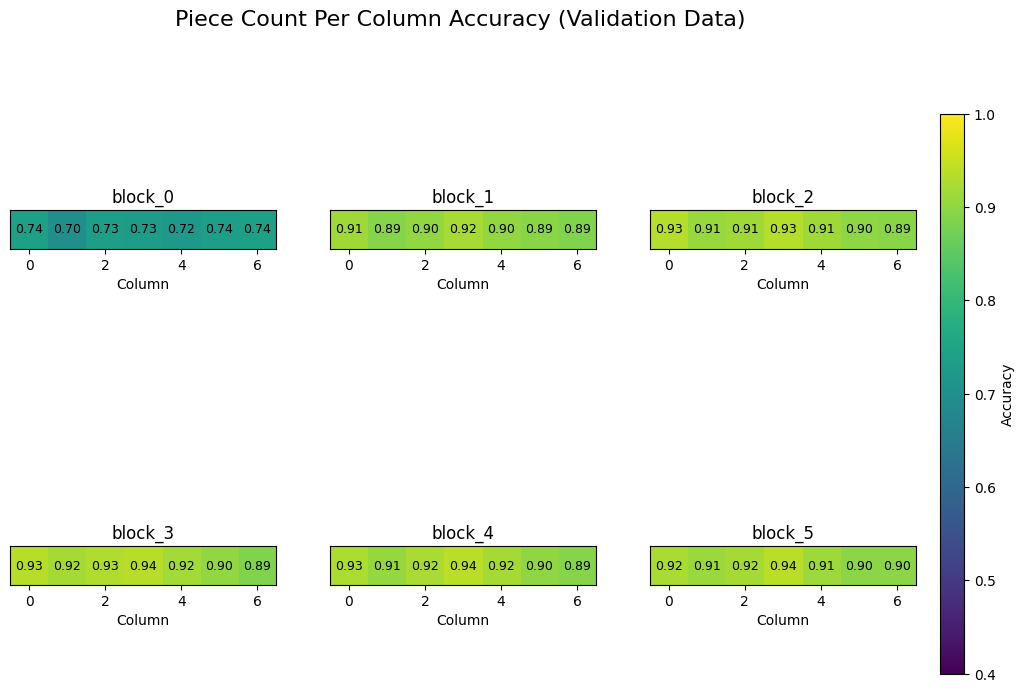

In [45]:
plot_heatmaps(val_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Validation Data)', xlabel='Column', ylabel='', disable_yticks=True)

Per row

In [46]:
train_acc_row, val_acc_row = eval_probe_results(row_probe_results, dim=train_Y_row.shape[-1])

In [47]:
train_acc_row

{'block_0': tensor([0.7388, 0.7125, 0.7033, 0.7129, 0.7268, 0.7469], device='cuda:0'),
 'block_1': tensor([0.8250, 0.7577, 0.7499, 0.7677, 0.7720, 0.8119], device='cuda:0'),
 'block_2': tensor([0.8728, 0.7862, 0.7764, 0.7836, 0.7831, 0.8288], device='cuda:0'),
 'block_3': tensor([0.8968, 0.7905, 0.7808, 0.7894, 0.7858, 0.8306], device='cuda:0'),
 'block_4': tensor([0.9118, 0.7883, 0.7794, 0.7899, 0.7848, 0.8264], device='cuda:0'),
 'block_5': tensor([0.9076, 0.7843, 0.7793, 0.7912, 0.7809, 0.8250], device='cuda:0')}

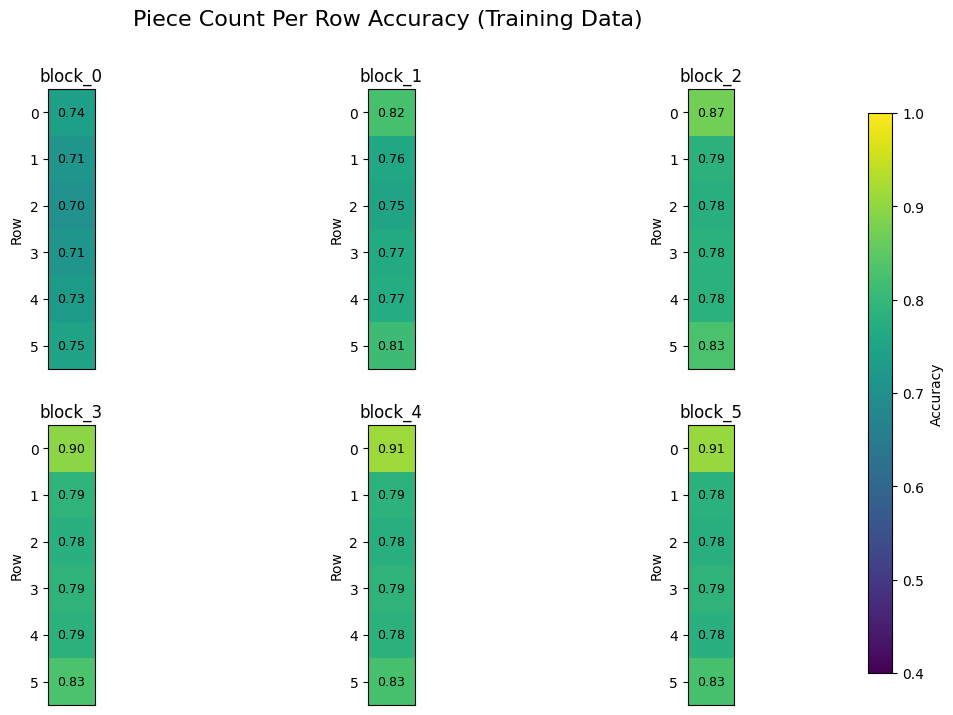

In [48]:
plot_heatmaps(train_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Training Data)', xlabel='', ylabel='Row', disable_xticks=True)

In [49]:
val_acc_row

{'block_0': tensor([0.7341, 0.7241, 0.6940, 0.6987, 0.6982, 0.7278], device='cuda:0'),
 'block_1': tensor([0.7949, 0.7516, 0.7246, 0.7400, 0.7447, 0.7891], device='cuda:0'),
 'block_2': tensor([0.8430, 0.7717, 0.7426, 0.7431, 0.7542, 0.8044], device='cuda:0'),
 'block_3': tensor([0.8658, 0.7653, 0.7479, 0.7532, 0.7548, 0.8002], device='cuda:0'),
 'block_4': tensor([0.8816, 0.7542, 0.7442, 0.7458, 0.7458, 0.8087], device='cuda:0'),
 'block_5': tensor([0.8747, 0.7537, 0.7315, 0.7410, 0.7468, 0.8018], device='cuda:0')}

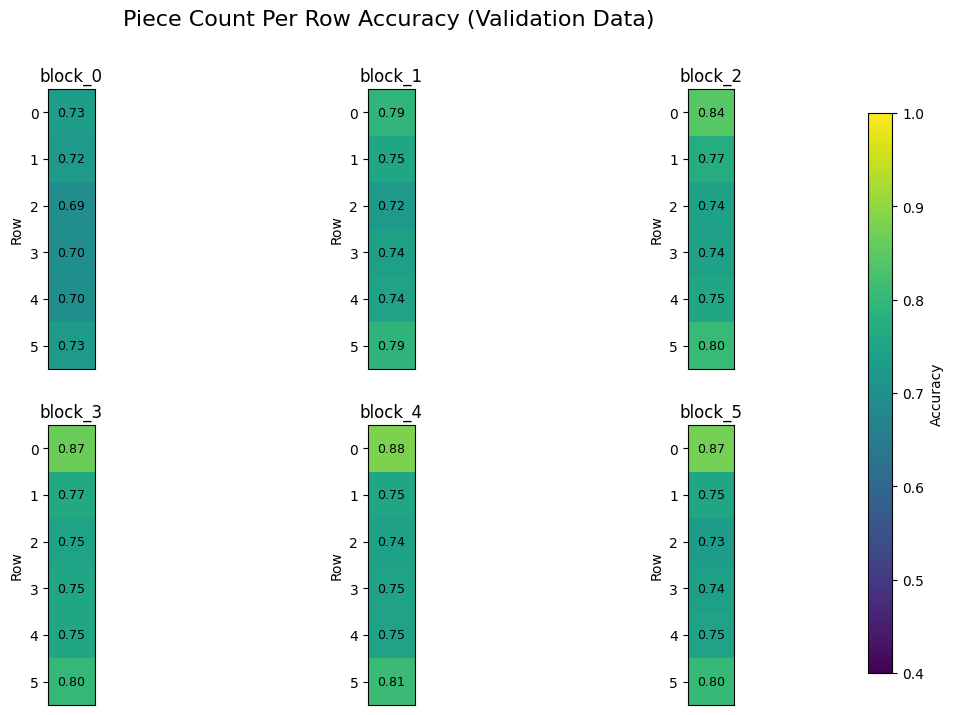

In [51]:
plot_heatmaps(val_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Validation Data)', xlabel='', ylabel='Row', disable_xticks=True)

### Train Attention (QKV) Probes

For cell $y$:
$$ \alpha_y = \text{softmax}(Q_y K) $$
$$ z_y = \sum_{t} \alpha_{y,t} V_t $$
Final prediction:
$$ \text{MLP}(z_y) $$

In [15]:
class AttentionProbe(nn.Module):
    def __init__(self, dim_x, dim_y, num_cls):
        super().__init__()

        self._dim_x = dim_x
        self._dim_y = dim_y
        self._num_cls = num_cls

        self.q = nn.Parameter(torch.randn(dim_y, dim_x))
        self.mlp = nn.Sequential(
            nn.Linear(dim_x * dim_y, 128),
            nn.ReLU(),
            nn.Linear(128, dim_y * num_cls)
        )

    def forward(self, K, V, mask):
        scores = torch.einsum("yd,btd->byt", self.q, K)
        scores = scores.masked_fill(mask[:, None, :] == 0, -1e9)

        alpha = torch.softmax(scores, dim=-1)

        z = torch.einsum("byt,btd->byd", alpha, V)
        z = z.reshape(z.size(0), -1)

        out = self.mlp(z)

        return out.view(-1, self._dim_y, self._num_cls)

In [16]:
def train_attention_probe(train_K, train_V, train_mask, train_Y, num_cls):
    results = {}
    for block in train_K.keys():
        print(block)

        probe = AttentionProbe(
            dim_x=train_K[block].shape[-1],
            dim_y=train_Y.shape[-1],
            num_cls=num_cls
        ).to(DEVICE)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(
            probe.parameters(),
            lr=5e-4,
            weight_decay=5e-5
        )

        epochs = 200
        batch_size = 4096
        N = train_K[block].shape[0]

        for epoch in range(epochs):
            probe.train()

            perm = torch.randperm(N)
            total_loss = 0.0

            for i in range(0, N, batch_size):
                idx = perm[i:i+batch_size]

                K = train_K[block][idx].to(DEVICE)
                V = train_V[block][idx].to(DEVICE)
                mask = train_mask[block][idx].to(DEVICE)
                Y = train_Y[idx].to(DEVICE)

                logits = probe(K, V, mask)

                loss = criterion(
                    logits.view(-1, logits.size(-1)),
                    Y.view(-1)
                )

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * K.size(0)

            avg_loss = total_loss / N
            if epoch % 50 == 0:
                print(f"Epoch {epoch} | train loss {avg_loss:.4f}")

        print(f"Epoch {epoch} | train loss {avg_loss:.4f}")
        results[block] = probe

    return results

Per cell

In [17]:
cell_attention_probe_results = train_attention_probe(train_K, train_V, train_KV_mask, train_Y_cell, num_cls=3)

block_0
Epoch 0 | train loss 0.9816
Epoch 50 | train loss 0.2959
Epoch 100 | train loss 0.2546
Epoch 150 | train loss 0.2328
Epoch 199 | train loss 0.2190
block_1
Epoch 0 | train loss 0.9446
Epoch 50 | train loss 0.1601
Epoch 100 | train loss 0.1190
Epoch 150 | train loss 0.0948
Epoch 199 | train loss 0.0802
block_2
Epoch 0 | train loss 0.9246
Epoch 50 | train loss 0.1336
Epoch 100 | train loss 0.0930
Epoch 150 | train loss 0.0735
Epoch 199 | train loss 0.0614
block_3
Epoch 0 | train loss 0.9578
Epoch 50 | train loss 0.1973
Epoch 100 | train loss 0.1411
Epoch 150 | train loss 0.1123
Epoch 199 | train loss 0.0942
block_4
Epoch 0 | train loss 0.9698
Epoch 50 | train loss 0.2043
Epoch 100 | train loss 0.1406
Epoch 150 | train loss 0.1074
Epoch 199 | train loss 0.0865
block_5
Epoch 0 | train loss 0.9797
Epoch 50 | train loss 0.2277
Epoch 100 | train loss 0.1665
Epoch 150 | train loss 0.1324
Epoch 199 | train loss 0.1099


Per column

In [18]:
col_attention_probe_results = train_attention_probe(train_K, train_V, train_KV_mask, train_Y_col, num_cls=7)

block_0
Epoch 0 | train loss 1.8740
Epoch 50 | train loss 0.9677
Epoch 100 | train loss 0.6893
Epoch 150 | train loss 0.4694
Epoch 199 | train loss 0.3579
block_1
Epoch 0 | train loss 1.8202
Epoch 50 | train loss 0.5388
Epoch 100 | train loss 0.3694
Epoch 150 | train loss 0.2884
Epoch 199 | train loss 0.2344
block_2
Epoch 0 | train loss 1.8349
Epoch 50 | train loss 0.3305
Epoch 100 | train loss 0.1843
Epoch 150 | train loss 0.1198
Epoch 199 | train loss 0.0843
block_3
Epoch 0 | train loss 1.8671
Epoch 50 | train loss 0.4273
Epoch 100 | train loss 0.2593
Epoch 150 | train loss 0.1850
Epoch 199 | train loss 0.1410
block_4
Epoch 0 | train loss 1.8684
Epoch 50 | train loss 0.4356
Epoch 100 | train loss 0.2824
Epoch 150 | train loss 0.2080
Epoch 199 | train loss 0.1633
block_5
Epoch 0 | train loss 1.8424
Epoch 50 | train loss 0.5203
Epoch 100 | train loss 0.3580
Epoch 150 | train loss 0.2726
Epoch 199 | train loss 0.2196


Per row

In [19]:
row_attention_probe_results = train_attention_probe(train_K, train_V, train_KV_mask, train_Y_row, num_cls=8)

block_0
Epoch 0 | train loss 1.9829
Epoch 50 | train loss 0.8510
Epoch 100 | train loss 0.7912
Epoch 150 | train loss 0.7512
Epoch 199 | train loss 0.7207
block_1
Epoch 0 | train loss 1.9725
Epoch 50 | train loss 0.6623
Epoch 100 | train loss 0.5348
Epoch 150 | train loss 0.4559
Epoch 199 | train loss 0.4034
block_2
Epoch 0 | train loss 1.9546
Epoch 50 | train loss 0.5662
Epoch 100 | train loss 0.4427
Epoch 150 | train loss 0.3671
Epoch 199 | train loss 0.3173
block_3
Epoch 0 | train loss 1.9879
Epoch 50 | train loss 0.6353
Epoch 100 | train loss 0.4880
Epoch 150 | train loss 0.4012
Epoch 199 | train loss 0.3457
block_4
Epoch 0 | train loss 1.9661
Epoch 50 | train loss 0.6752
Epoch 100 | train loss 0.5181
Epoch 150 | train loss 0.4367
Epoch 199 | train loss 0.3821
block_5
Epoch 0 | train loss 1.9809
Epoch 50 | train loss 0.6875
Epoch 100 | train loss 0.5510
Epoch 150 | train loss 0.4732
Epoch 199 | train loss 0.4196


### Test Attention Probes

In [20]:
def eval_attention_probe_results(probes, Ks, Vs, masks, Ys, dim):
    acc = {}
    batch_size = 2048

    for block in probes.keys():
        probe = probes[block]
        probe.eval()

        N = Ks[block].shape[0]

        correct = torch.zeros(dim, device=DEVICE)
        total = torch.zeros(dim, device=DEVICE)

        for i in range(0, N, batch_size):
            K = Ks[block][i:i+batch_size].to(DEVICE)
            V = Vs[block][i:i+batch_size].to(DEVICE)
            mask = masks[block][i:i+batch_size].to(DEVICE)
            Y = Ys[i:i+batch_size].to(DEVICE)

            logits = probe(K, V, mask)
            pred = logits.argmax(dim=-1)
            matches = (pred == Y).float()

            correct += matches.sum(dim=0)
            total += torch.ones_like(matches).sum(dim=0)

        acc[block] = correct / total

    return acc

Per cell

In [21]:
train_attention_acc_cell = eval_attention_probe_results(cell_attention_probe_results, train_K, train_V, train_KV_mask, train_Y_cell, train_Y_cell.shape[-1])
train_attention_acc_cell

{'block_0': tensor([0.9208, 0.9277, 0.9344, 0.9416, 0.9461, 0.9611, 0.9779, 0.8729, 0.8824,
         0.8889, 0.8852, 0.9139, 0.9284, 0.9560, 0.8354, 0.8323, 0.8484, 0.8438,
         0.8713, 0.9054, 0.9432, 0.8205, 0.8056, 0.8170, 0.8132, 0.8489, 0.8802,
         0.9168, 0.8296, 0.8414, 0.8379, 0.8703, 0.8602, 0.8865, 0.9083, 0.9460,
         0.9546, 0.9696, 0.9904, 0.9656, 0.9657, 0.9657], device='cuda:0'),
 'block_1': tensor([0.9799, 0.9907, 0.9941, 0.9958, 0.9956, 0.9939, 0.9985, 0.9314, 0.9434,
         0.9497, 0.9570, 0.9667, 0.9717, 0.9860, 0.9394, 0.9473, 0.9596, 0.9511,
         0.9582, 0.9639, 0.9780, 0.9334, 0.9490, 0.9632, 0.9688, 0.9592, 0.9631,
         0.9620, 0.9395, 0.9696, 0.9865, 0.9966, 0.9833, 0.9701, 0.9641, 0.9977,
         0.9994, 0.9998, 0.9999, 0.9999, 0.9993, 0.9971], device='cuda:0'),
 'block_2': tensor([0.9994, 0.9988, 0.9991, 0.9992, 0.9999, 0.9999, 0.9998, 0.9669, 0.9697,
         0.9750, 0.9768, 0.9792, 0.9912, 0.9920, 0.9591, 0.9569, 0.9660, 0.9722,
     

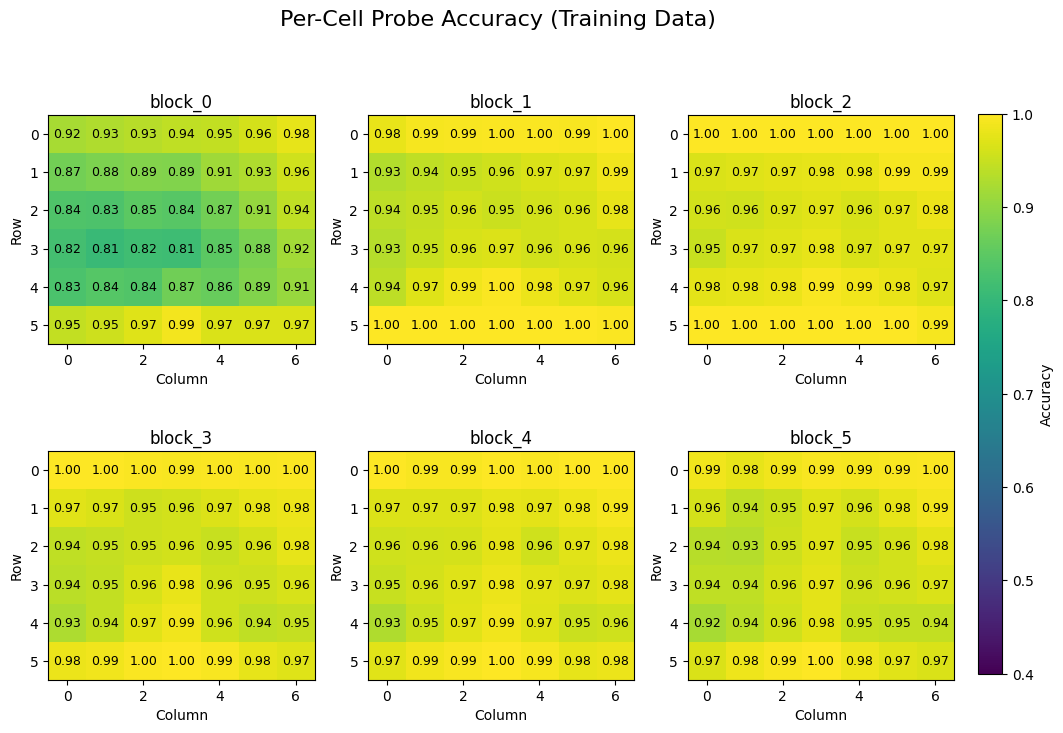

In [22]:
plot_heatmaps(train_attention_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Training Data)', xlabel='Column', ylabel='Row')

In [23]:
val_attention_acc_cell = eval_attention_probe_results(cell_attention_probe_results, val_K, val_V, val_KV_mask, val_Y_cell, val_Y_cell.shape[-1])
val_attention_acc_cell

{'block_0': tensor([0.8927, 0.9070, 0.9038, 0.9228, 0.9234, 0.9424, 0.9662, 0.8510, 0.8578,
         0.8578, 0.8605, 0.8943, 0.9181, 0.9450, 0.8161, 0.8124, 0.8187, 0.8293,
         0.8547, 0.8858, 0.9276, 0.7997, 0.7859, 0.7939, 0.7933, 0.8129, 0.8547,
         0.8922, 0.8224, 0.8298, 0.8118, 0.8689, 0.8409, 0.8615, 0.8969, 0.9313,
         0.9456, 0.9556, 0.9826, 0.9498, 0.9572, 0.9540], device='cuda:0'),
 'block_1': tensor([0.9160, 0.9461, 0.9519, 0.9551, 0.9524, 0.9561, 0.9794, 0.8584, 0.8784,
         0.8763, 0.8742, 0.9043, 0.9202, 0.9440, 0.8177, 0.8679, 0.8636, 0.8710,
         0.8805, 0.9022, 0.9265, 0.8187, 0.8414, 0.8811, 0.9191, 0.8938, 0.8895,
         0.8975, 0.8636, 0.9101, 0.9371, 0.9625, 0.9493, 0.9212, 0.9101, 0.9688,
         0.9815, 0.9900, 0.9915, 0.9884, 0.9826, 0.9730], device='cuda:0'),
 'block_2': tensor([0.9672, 0.9704, 0.9678, 0.9688, 0.9752, 0.9741, 0.9778, 0.8890, 0.9022,
         0.9049, 0.9117, 0.9165, 0.9355, 0.9445, 0.8747, 0.8700, 0.8864, 0.9080,
     

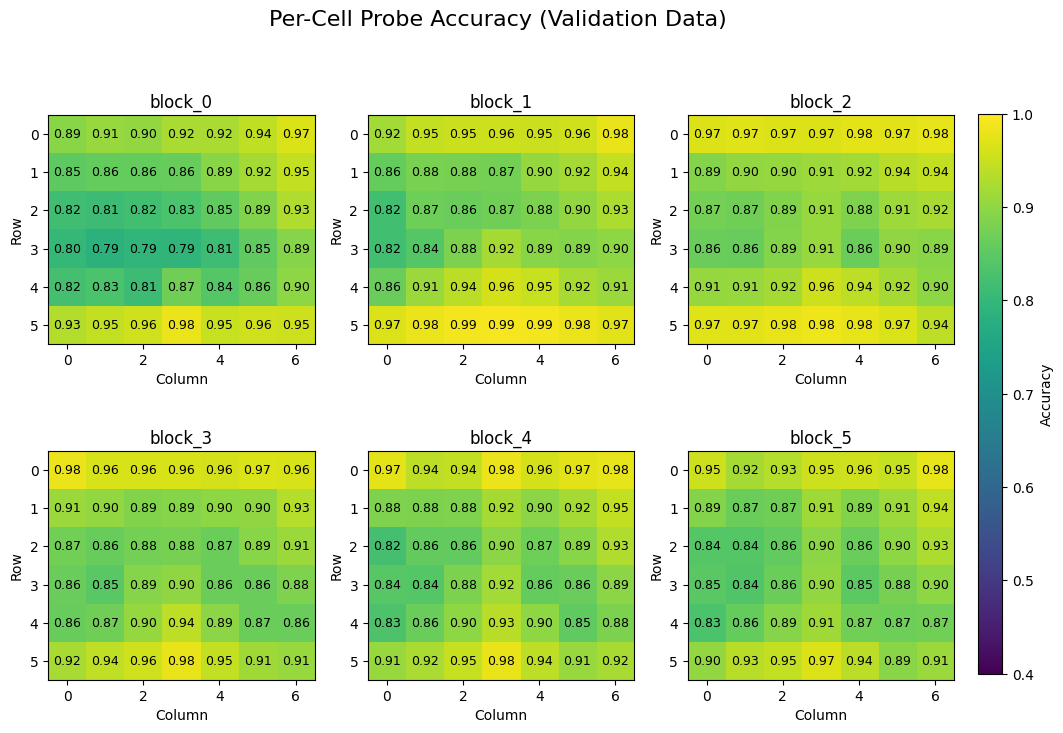

In [24]:
plot_heatmaps(val_attention_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Validation Data)', xlabel='Column', ylabel='Row')

Per column

In [25]:
train_attention_acc_col = eval_attention_probe_results(col_attention_probe_results, train_K, train_V, train_KV_mask, train_Y_col, train_Y_col.shape[-1])
train_attention_acc_col

{'block_0': tensor([0.9117, 0.8516, 0.8128, 0.8676, 0.9126, 0.9128, 0.9075],
        device='cuda:0'),
 'block_1': tensor([0.9267, 0.9125, 0.9092, 0.9281, 0.9134, 0.9216, 0.9342],
        device='cuda:0'),
 'block_2': tensor([0.9896, 0.9837, 0.9836, 0.9889, 0.9860, 0.9798, 0.9754],
        device='cuda:0'),
 'block_3': tensor([0.9685, 0.9622, 0.9689, 0.9770, 0.9615, 0.9586, 0.9522],
        device='cuda:0'),
 'block_4': tensor([0.9530, 0.9628, 0.9663, 0.9737, 0.9407, 0.9456, 0.9563],
        device='cuda:0'),
 'block_5': tensor([0.9359, 0.9335, 0.9369, 0.9626, 0.9239, 0.9237, 0.9160],
        device='cuda:0')}

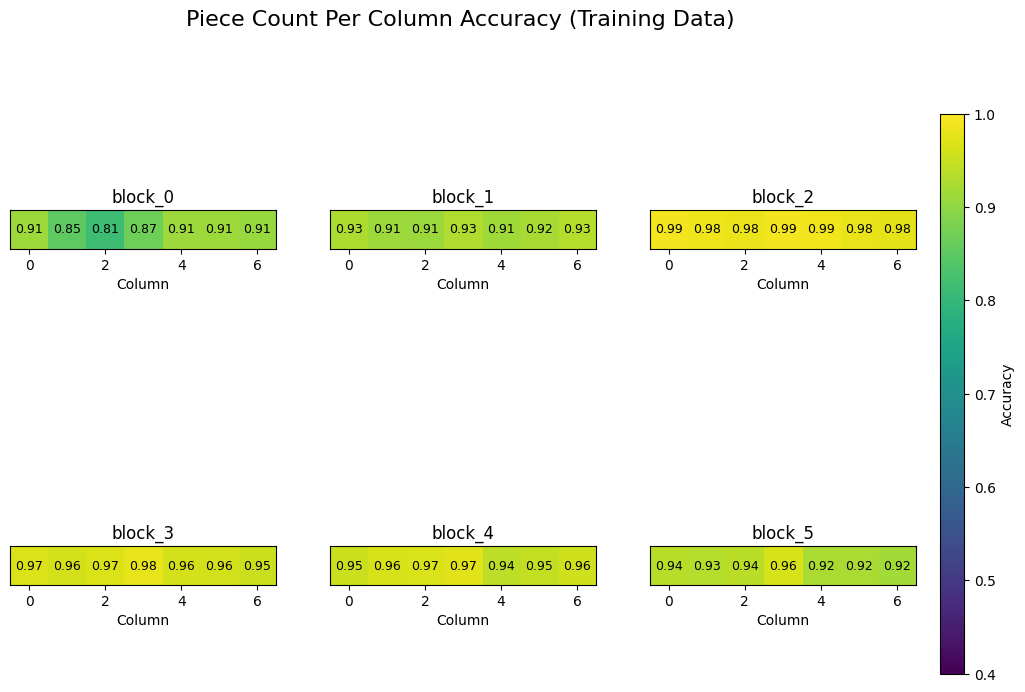

In [26]:
plot_heatmaps(train_attention_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Training Data)', xlabel='Column', ylabel='', disable_yticks=True)

In [27]:
val_attention_acc_col = eval_attention_probe_results(col_attention_probe_results, val_K, val_V, val_KV_mask, val_Y_col, val_Y_col.shape[-1])
val_attention_acc_col

{'block_0': tensor([0.8975, 0.8325, 0.7859, 0.8647, 0.9107, 0.9001, 0.8906],
        device='cuda:0'),
 'block_1': tensor([0.8753, 0.8573, 0.8541, 0.8784, 0.8679, 0.8695, 0.8885],
        device='cuda:0'),
 'block_2': tensor([0.9625, 0.9376, 0.9450, 0.9619, 0.9508, 0.9197, 0.9292],
        device='cuda:0'),
 'block_3': tensor([0.9334, 0.9006, 0.9154, 0.9334, 0.9012, 0.8911, 0.8758],
        device='cuda:0'),
 'block_4': tensor([0.9027, 0.9096, 0.8990, 0.9223, 0.8800, 0.8795, 0.8895],
        device='cuda:0'),
 'block_5': tensor([0.8832, 0.8647, 0.8747, 0.9313, 0.8642, 0.8346, 0.8467],
        device='cuda:0')}

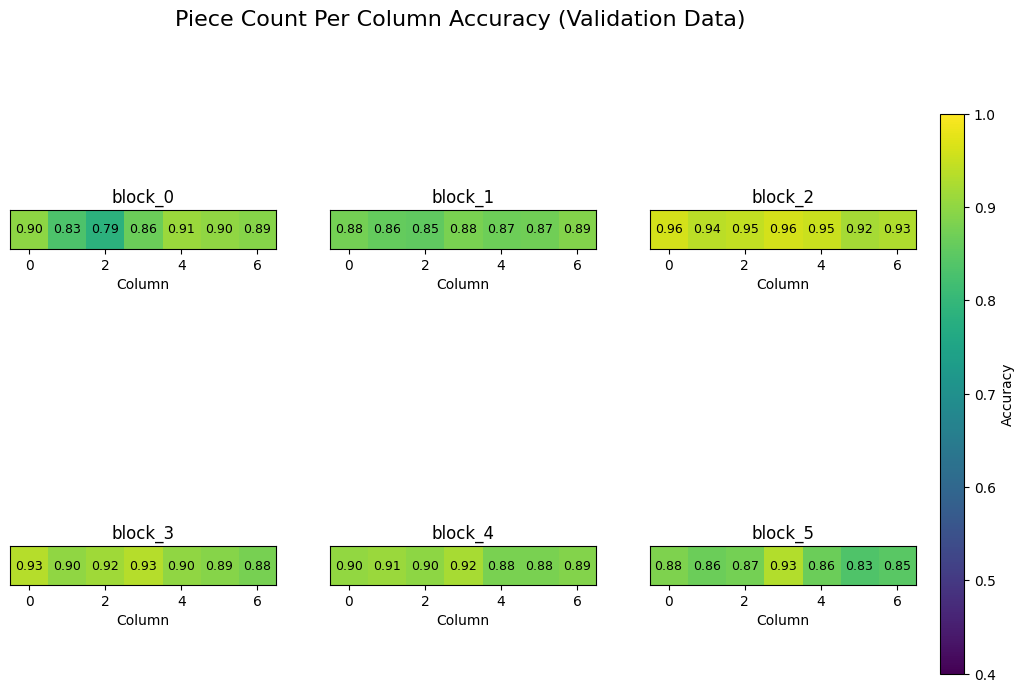

In [28]:
plot_heatmaps(val_attention_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Validation Data)', xlabel='Column', ylabel='', disable_yticks=True)

Per row

In [29]:
train_attention_acc_row = eval_attention_probe_results(row_attention_probe_results, train_K, train_V, train_KV_mask, train_Y_row, train_Y_row.shape[-1])
train_attention_acc_row

{'block_0': tensor([0.7035, 0.6849, 0.6839, 0.6696, 0.6559, 0.6916], device='cuda:0'),
 'block_1': tensor([0.8384, 0.8227, 0.8159, 0.8342, 0.8282, 0.8867], device='cuda:0'),
 'block_2': tensor([0.9279, 0.8775, 0.8609, 0.8561, 0.8607, 0.8992], device='cuda:0'),
 'block_3': tensor([0.9333, 0.8627, 0.8524, 0.8499, 0.8355, 0.8831], device='cuda:0'),
 'block_4': tensor([0.9271, 0.8437, 0.8315, 0.8306, 0.8124, 0.8686], device='cuda:0'),
 'block_5': tensor([0.9169, 0.8236, 0.8159, 0.8118, 0.7944, 0.8353], device='cuda:0')}

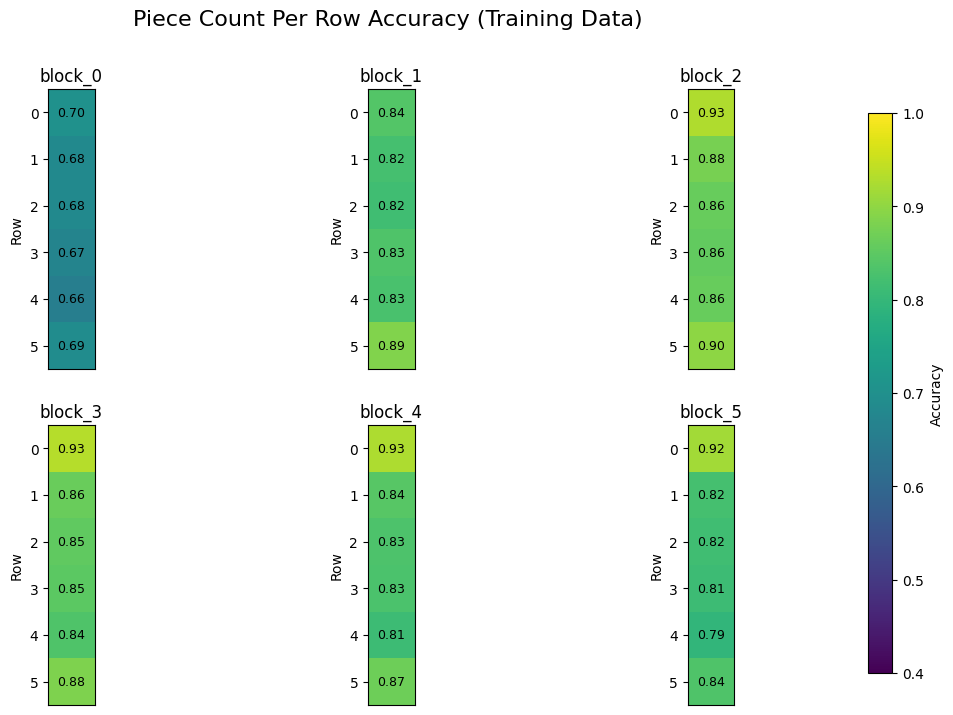

In [30]:
plot_heatmaps(train_attention_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Training Data)', xlabel='', ylabel='Row', disable_xticks=True)

In [31]:
val_attention_acc_row = eval_attention_probe_results(row_attention_probe_results, val_K, val_V, val_KV_mask, val_Y_row, val_Y_row.shape[-1])
val_attention_acc_row

{'block_0': tensor([0.6760, 0.6575, 0.6543, 0.6311, 0.6089, 0.6792], device='cuda:0'),
 'block_1': tensor([0.7505, 0.7437, 0.6982, 0.7389, 0.7310, 0.8203], device='cuda:0'),
 'block_2': tensor([0.8393, 0.7986, 0.7426, 0.7368, 0.7415, 0.8034], device='cuda:0'),
 'block_3': tensor([0.8483, 0.7368, 0.7389, 0.7114, 0.7220, 0.8007], device='cuda:0'),
 'block_4': tensor([0.8404, 0.7447, 0.7162, 0.7352, 0.6913, 0.7844], device='cuda:0'),
 'block_5': tensor([0.8499, 0.7267, 0.7289, 0.7178, 0.6961, 0.7643], device='cuda:0')}

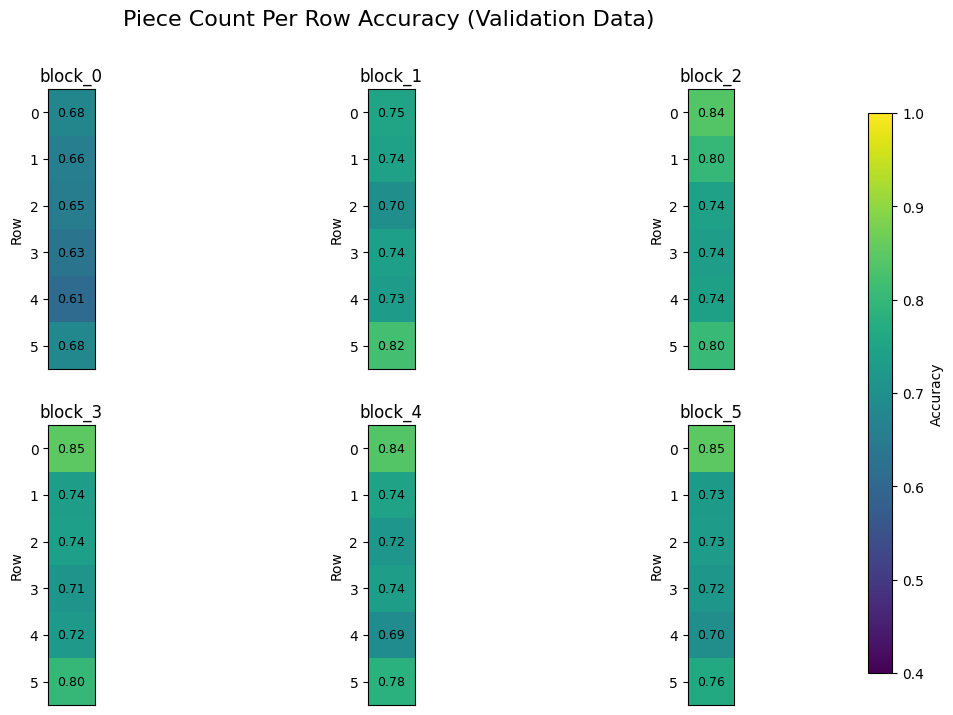

In [32]:
plot_heatmaps(val_attention_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Validation Data)', xlabel='', ylabel='Row', disable_xticks=True)

### Visualize learned Q vectors

In [33]:
from sklearn.decomposition import PCA

In [34]:
def plot_q_pca_layers(
    probes_dict,
    board_shape=(6,7),
    title="PCA of q vectors per layer",
    probe_name="Cell probe",
    max_cols=3,
    color_by="col"
):
    keys = sorted(probes_dict.keys())
    n = len(keys)

    cols = min(n, max_cols)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(
        rows,
        cols,
        figsize=(4 * cols, 4 * rows),
        squeeze=False
    )

    fig.suptitle(f"{title} ({probe_name})", fontsize=16)

    H, W = board_shape

    for idx, key in enumerate(keys):
        r = idx // cols
        c = idx % cols
        ax = axes[r][c]

        probe = probes_dict[key]
        q = probe.q.detach().cpu().numpy()

        q2 = PCA(n_components=2).fit_transform(q)

        if color_by == "row":
            colors = [i // W for i in range(H*W)]
        elif color_by == "col":
            colors = [i % W for i in range(H*W)]
        else:
            colors = None

        ax.scatter(q2[:,0], q2[:,1], c=colors)

        for i,(x,y) in enumerate(q2):
            rr = i // W
            cc = i % W
            txt = f"{cc}" if H == 1 else f"{rr}" if W == 1 else f"{rr},{cc}"
            ax.text(x, y, txt, fontsize=7)

        ax.set_title(key)
        ax.set_xticks([])
        ax.set_yticks([])

    for i in range(n, rows * cols):
        fig.delaxes(axes[i // cols][i % cols])

    plt.tight_layout()
    plt.show()

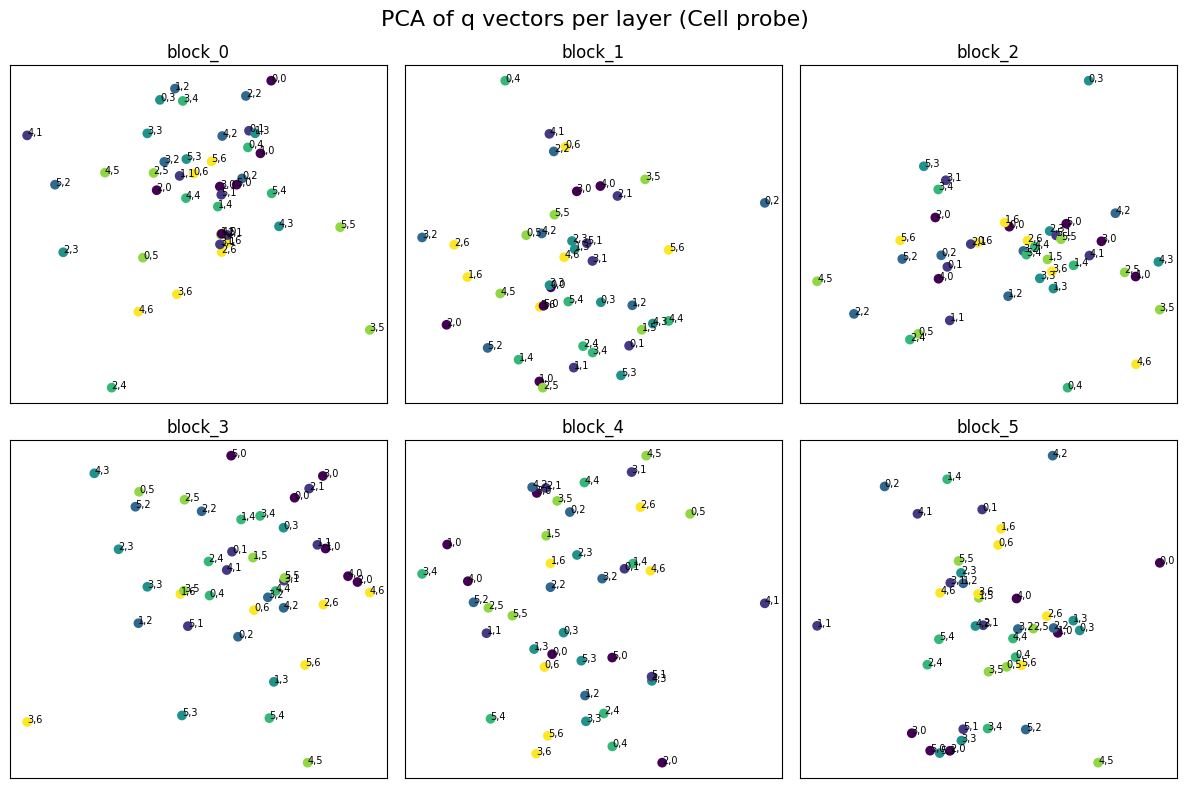

In [35]:
plot_q_pca_layers(cell_attention_probe_results)

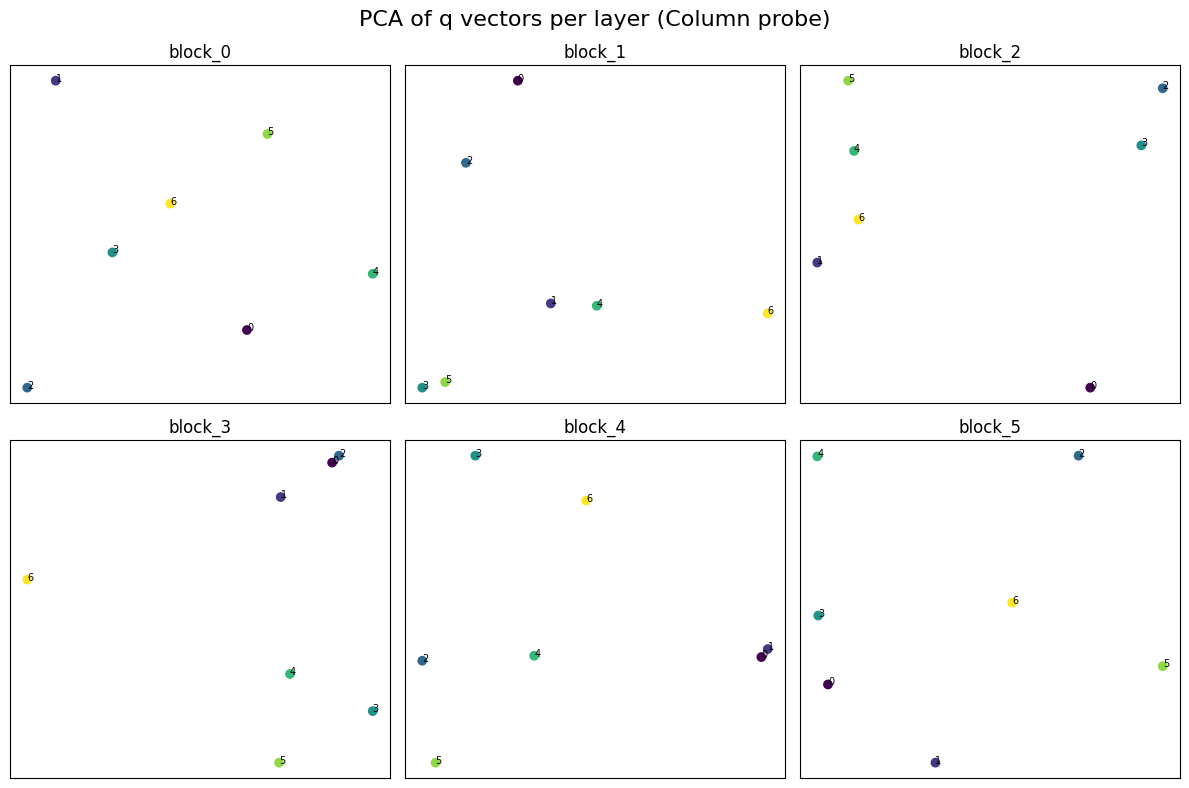

In [36]:
plot_q_pca_layers(col_attention_probe_results, board_shape=(1,7), probe_name="Column probe")

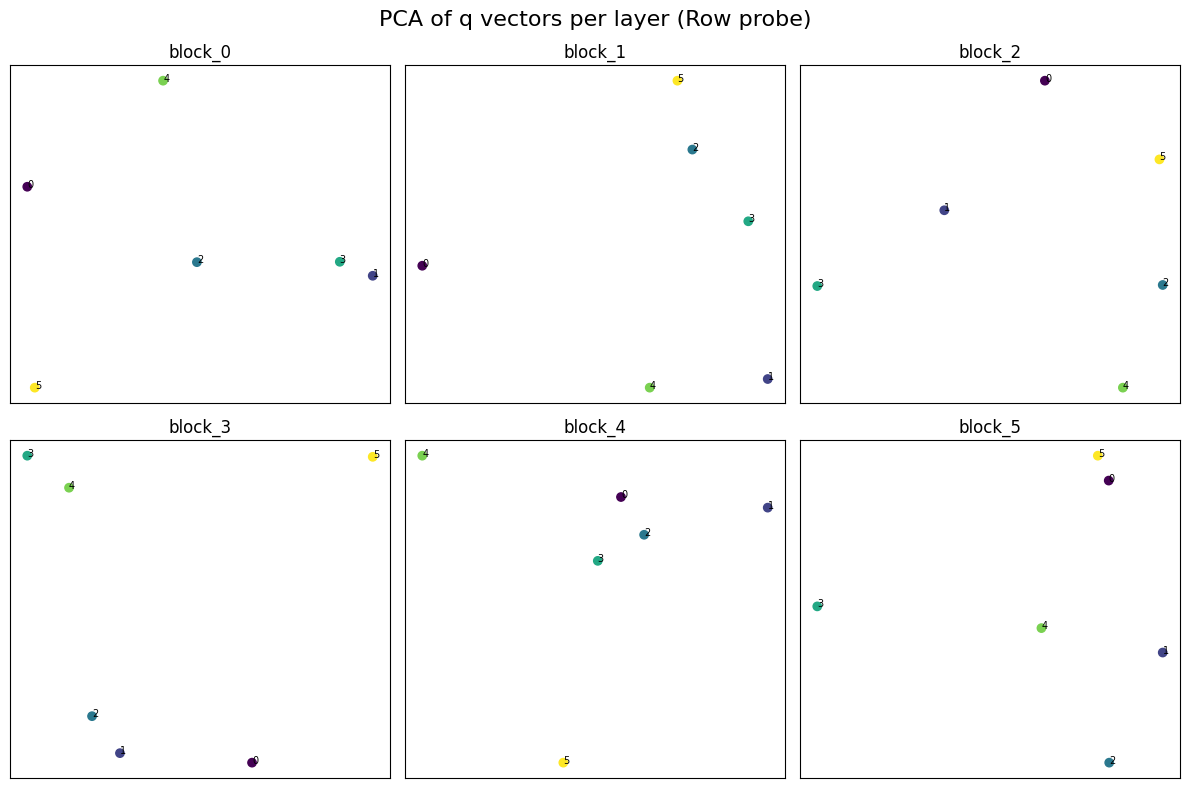

In [37]:
plot_q_pca_layers(row_attention_probe_results, board_shape=(6,1), probe_name="Row probe", color_by="row")